In [39]:
#%matplotlib notebook
#%run imports.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import string
import sys
import os 
import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import seaborn as sns
import umap
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la


from Utils import *

In [40]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-29 08:18:11CEST

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

sklearn: 1.5.1

black        : 24.4.2
igraph       : 0.11.6
sys          : 3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy        : 2.0.1
sklearn      : 1.5.1
leidenalg    : 0.10.2
jupyter_black: 0.3.4
seaborn      : 0.13.2
pandas       : 2.2.2
matplotlib   : 3.9.1
json         : 2.0.9
scipy        : 1.14.0

Watermark: 2.4.3



In [41]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [42]:
plt.style.use("../matplotlib_style.txt")

In [43]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [44]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [45]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [46]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [48]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [49]:
cluster_colors.shape
print(len(np.unique(cluster_colors)))

78


In [50]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [51]:
ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

print(rna_type.shape)
print(rna_type)

(1329,)
['L5 ET_1' 'L5 IT_2' 'L5 IT_1' ... 'L5 ET_1' nan 'Pvalb Gpr149']


In [52]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [53]:
print(dict_rna_type_colors)
rna_type_colors_array = np.array(list(dict_rna_type_colors.values()))
print(len(rna_type_colors_array))
print(len(np.unique(rna_type_colors_array)))

{'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98', 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963', 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3', 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF', 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_1': '#F70CF3', 'Vip Chat_1': '#FF00FF', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00', 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09', 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652', 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Ca

### Electrophysiological features

In [54]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [55]:
ephys_pd = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

# print(ephys_pd["cell id"])
# print(ephys_pd.head())
# print(cells)

gene_data = pd.read_csv(data_path / "gene_lengths.txt")
print(gene_data.head())

          GeneID  exon_bp  intron_bp  gene_bp
0  0610005C13Rik     3583       3951     7534
1  0610006L08Rik     2128      32868    34996
2  0610009B22Rik      998       2491     3489
3  0610009E02Rik     1803      11892    13695
4  0610009L18Rik      619       1894     2513


In [56]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData

print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [57]:
ephysData_filtered

array([[ 0.98608392,  0.64834158, -0.93881053, ...,  3.04737527,
         0.16776081,  0.63710672],
       [ 0.58728941,  0.45548548, -0.80161871, ...,  2.96590616,
        -0.76260223,  0.99778569],
       [ 0.36748484,  0.036109  , -0.11310118, ...,  3.04737527,
        -0.31069552,  1.05910185],
       ...,
       [ 0.66987131, -0.0487444 , -0.34647255, ...,  4.75822642,
         0.21211713,  0.73777371],
       [ 0.41921208,  0.55079968, -0.32063559, ...,  3.61765898,
         0.10267565,  1.50108896],
       [-0.50165036, -0.14969752, -0.01064697, ...,  0.76624039,
        -1.16822945, -1.10823434]])

In [58]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

In [59]:
print(cluster_colors[keepcells].shape)
print(cluster_colors[keepcells][0:5])
for i in range(0, 5):
    print(cluster_colors[keepcells][i])
    for key, value in dict_rna_type_colors.items():
        if value == cluster_colors[keepcells][i]:
            print(key)

(1320,)
['#0D5D7E' '#4A9F93' '#58D2C1' '#0A75B1' '#0D5D7E']
#0D5D7E
L5 ET_1
#4A9F93
L5 IT_2
#58D2C1
L5 IT_1
#0A75B1
L5 ET_4
#0D5D7E
L5 ET_1


# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.

### Compile the cell types pandas dataframe (Artemii)

In [60]:
import json

# Convert rna_type to a Pandas Series if it is not already
rna_type = pd.Series(rna_type) if not isinstance(rna_type, pd.Series) else rna_type

# Remove NaNs from rna_type and count occurrences of each RNA type
rna_type_clean = rna_type.dropna()
rna_type_counts = rna_type_clean.value_counts().to_dict()

# Add a 'Not identified' key if there were NaNs in the original rna_type array
if rna_type.isnull().sum() > 0:
    rna_type_counts["Not identified"] = rna_type.isnull().sum()

# Sort the dictionary by keys
rna_type_counts = dict(sorted(rna_type_counts.items()))
# Move 'Not identified' to the end if it exists
if "Not identified" in rna_type_counts:
    rna_type_counts["Not identified"] = rna_type_counts.pop("Not identified")

# Create a DataFrame for cell types and their colors
cell_types = list(rna_type_counts.keys())
mapping_db = pd.DataFrame({"cell_types": cell_types})

# Assign colors to cell types
mapping_db["color"] = mapping_db["cell_types"].apply(
    lambda cell_type: dict_rna_type_colors.get(cell_type, "gray")
)

# Define marker lists based on the paper
excitatory_markers = [
    "L2/3 IT",
    "L4/5 IT",
    "L5 IT",
    "L6 IT",
    "L6b",
    "L6",
    "L5/6",
    "L5",
    "L6",
    "L2/3",
    "L4",
    "L5 IT",
    "L6 IT",
    "L6 CT",
    "L6b",
    "L6 CT",
]
cge_markers = ["Lamp5", "Sncg", "Vip"]
mge_markers = ["Sst", "Pvalb"]


# Assign types to cell types based on markers
def assign_type(cell_type):
    if any(marker in cell_type for marker in excitatory_markers):
        return "Excitatory neurons"
    if any(marker in cell_type for marker in cge_markers):
        return "CGE-derived interneurons"
    if any(marker in cell_type for marker in mge_markers):
        return "MGE-derived interneurons"
    return None


mapping_db["type"] = mapping_db["cell_types"].apply(assign_type)

# Add counts to the DataFrame
mapping_db["count"] = mapping_db["cell_types"].map(rna_type_counts)

# Sort the DataFrame by type and cell types
mapping_db = mapping_db.sort_values(by=["type", "cell_types"])

# Define groups
neuron_groups = [
    "Excitatory neurons",
    "CGE-derived interneurons",
    "MGE-derived interneurons",
]

#### Plotting function for cell types and classes

In [61]:
def plot_cell_types(groups: list, ax: plt.Axes, base_font_size: int = 8) -> None:
    """
    Plot cell types of the mapping database

    Parameters
    ----------

    groups: list
        List of groups to plot

    ax: plt.Axes
        Axis to plot on

    base_font_size: int
        Base font size for plotting

    Return
    ------
    None

    """
    global mapping_db
    x_base = 0
    xticks = []
    xticklabels = []

    max_height = max(mapping_db["count"])
    figsize = ax.get_figure().get_size_inches()
    width_factor = figsize[0] / 15
    height_factor = figsize[1] / 5
    font_size = calculate_font_size(base_font_size, min(width_factor, height_factor))

    for i, group in enumerate(groups):
        group_data = mapping_db[mapping_db["type"] == group]
        x_positions = np.arange(len(group_data)) + x_base

        ax.bar(x_positions, group_data["count"], color=group_data["color"], width=0.8)

        ax.text(
            x_base + (len(group_data) - 1) / 2,
            max_height - 10,
            group,
            ha="center",
            va="bottom",
            fontsize=font_size * 1.2,
            fontweight="bold",
        )

        xticks.extend(x_positions)
        xticklabels.extend(group_data["cell_types"])

        x_base += len(group_data) + 1  # Increment x_base for next group

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=font_size)

    ax.set_ylabel("Count")

## Analisys of ePhys Data (Artemii)

In [62]:
# Use knn_classification to classify the original data

Data = ephysData_filtered
labels = cluster_colors[keepcells]
print(Data.shape)
print(cluster_colors[keepcells].shape)
# print(np.unique(cluster_colors[keepcells]))
accuracy, recall = knn_classification(Data, labels)
print(f"Original data label accuracy: {accuracy:.2f}")
print(f"Original data label recall: {recall:.2f}")

(1320, 17)
(1320,)
Original data label accuracy: 0.34
Original data label recall: 0.34


### Exploring and plotting different dimensionality reduction methods

In [63]:
# perform different dimensionality reduction techniques
reduced_data = dim_reduction(ephysData_filtered, cluster_colors[keepcells])

PCA accuracy: 0.22
PCA recall: 0.22
NCA accuracy: 0.24
NCA recall: 0.24
LDA accuracy: 0.24
LDA recall: 0.24


/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 0.98, 'Different dimensionality reduction methods for ePhys data')

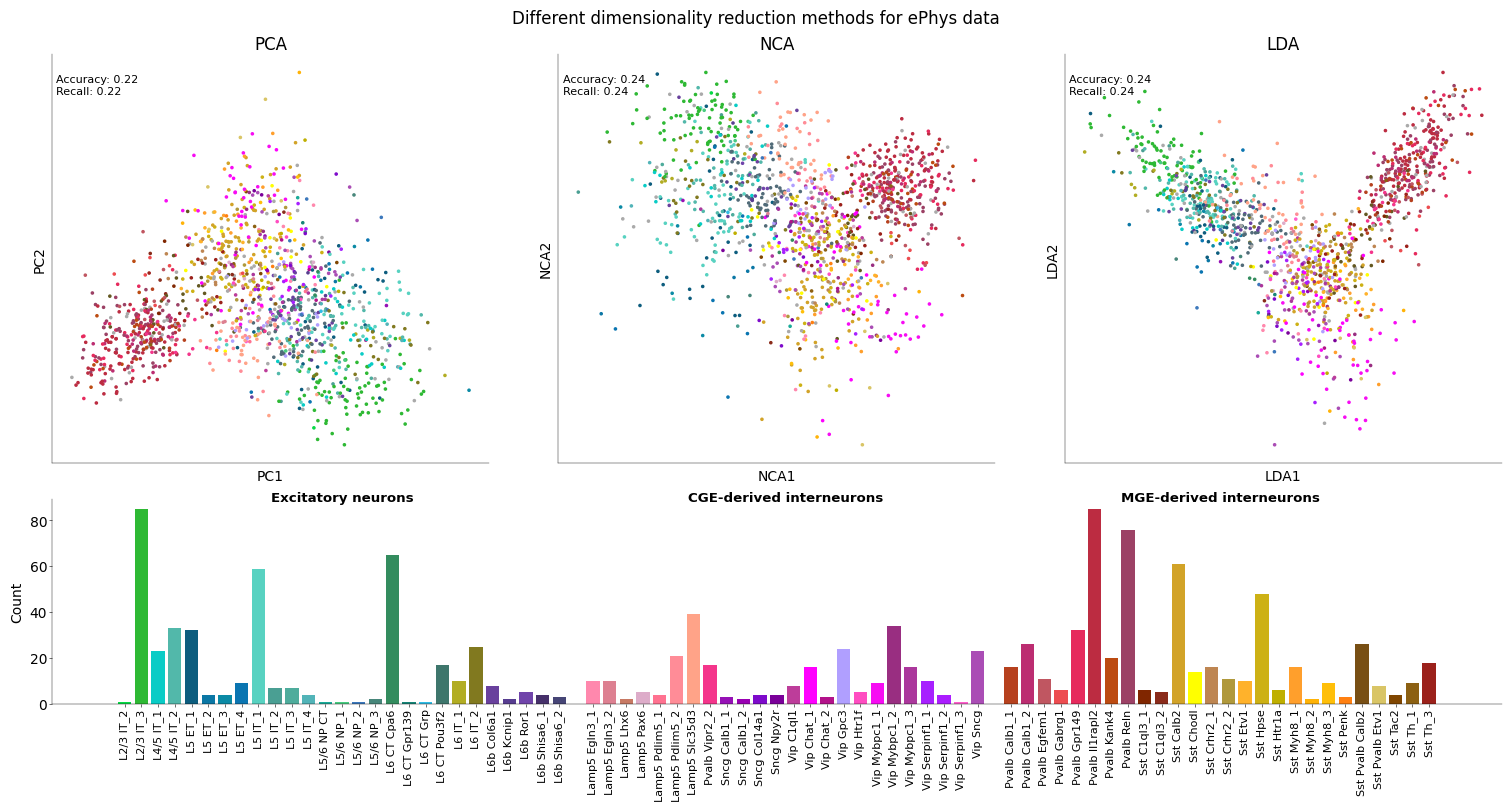

In [64]:
fig = plt.figure(figsize=(15, 8))

gs = GridSpec(2, 3, figure=fig, wspace=0.05, height_ratios=[2, 1])
# Create subplots with the specified gridspec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])


axs = [ax0, ax1, ax2]
for i, (key, value) in enumerate(reduced_data.items()):
    plot_dim1_dim2(
        ax=axs[i],
        data=reduced_data,
        labels=cluster_colors[keepcells],
        type=key,
        title=key,
        display_stats=True,
    )
plot_cell_types(neuron_groups, ax3)
plt.suptitle("Different dimensionality reduction methods for ePhys data")

The figure demonstrates that NCA and LDA methods for dimensionality reduction seem to be slightly more accurate than PCA. Since the difference is not dramatic, we will use PCA (being the most common method) further on.

### Representing ePhys data in PCA, TSNE and UMAP spaces. Performing and visuzalizing GMM-clustering on raw data.

Optimal number of clusters: 4


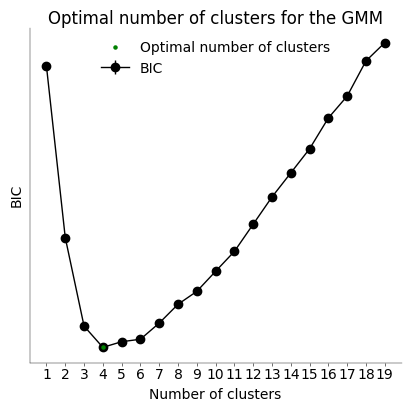

In [65]:
### GMM CLUSTERING ###

# set the range of possible cluster number
possible_clusters = np.arange(1, 20, 1)
num_seeds = 1

# get the optimal cluster number using BIC
ePhys_cluster_n = get_optimal_cluster_number(
    possible_clusters, num_seeds, ephysData_filtered, bic_mode="sklearn", plot=True
)

# fit the GMM model
ePhys_gmm = GMM(n_components=ePhys_cluster_n, random_state=42).fit(ephysData_filtered)

# get the cluster labels, means and covariances
ePhys_clusters = ePhys_gmm.predict(ephysData_filtered)
ePhys_clusters_means = ePhys_gmm.means_
ePhys_clusters_covariances = ePhys_gmm.covariances_

In [66]:
# transform cluster means and covariances to PCA space for plotting later
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pca_ePhys = pca.fit(ephysData_filtered)
ePhys_clusters_means = pca.transform(ePhys_clusters_means)
components = pca[pca.steps[-1][0]].components_
ePhys_clusters_covariances = [
    components @ cov @ components.T for cov in ePhys_clusters_covariances
]

In [67]:
### TSNE ###
# performing t-SNE on the ePhys data
ePhys_tsne = TSNE(init="pca", early_exaggeration=4, random_state=42).fit_transform(
    ephysData_filtered
)

In [68]:
### UMAP ###
# performing UMAP on the ePhys data
umap_ePhys = umap.UMAP(random_state=42).fit_transform(ephysData_filtered)

/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_34313/789782938.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_34313/789782938.py:44: UserWarnin

Text(0.5, 0.98, 'PCA and tSNE of ePhys data with original labeling')

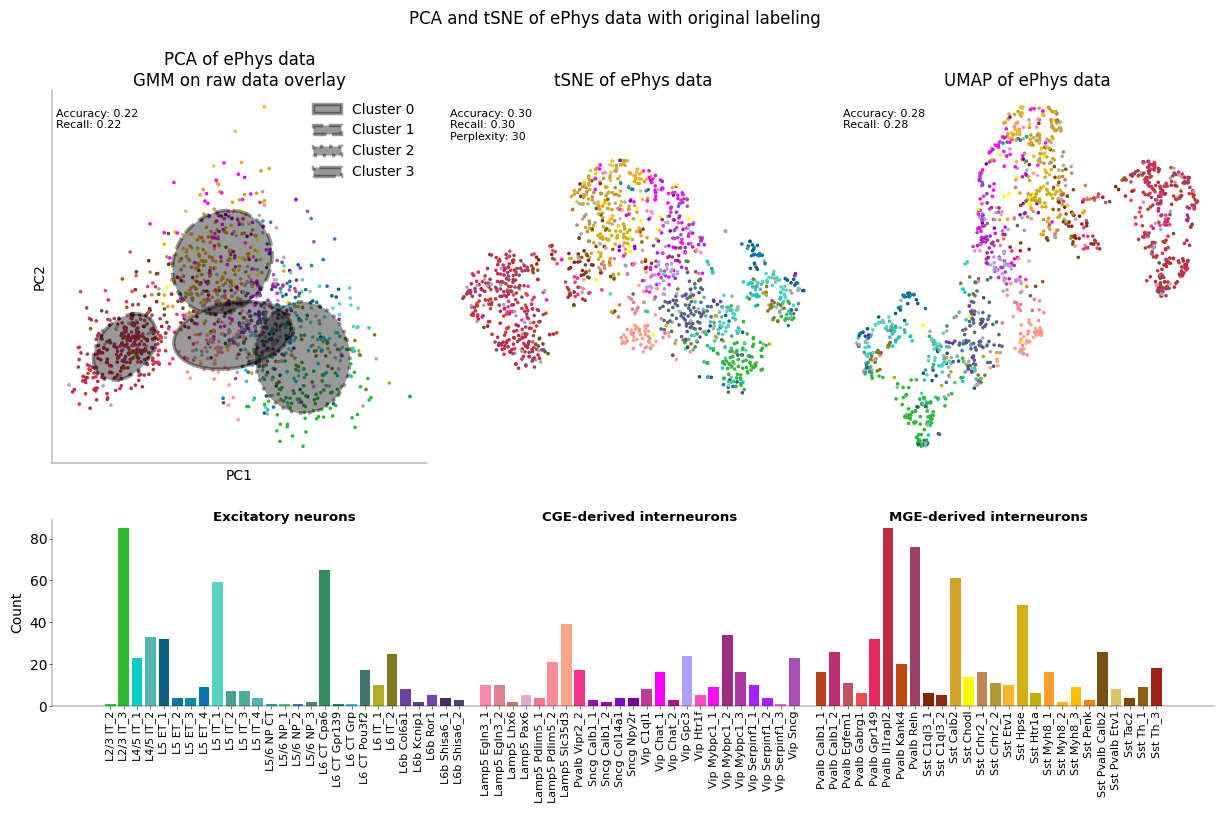

In [69]:
### PLOTTING ###
fig = plt.figure(figsize=(15, 8))

gs = GridSpec(2, 3, figure=fig, wspace=0.05, height_ratios=[2, 1])
# Create subplots with the specified gridspec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])


plot_dim1_dim2(
    ax0,
    reduced_data,
    cluster_colors[keepcells],
    "PCA of ePhys data\nGMM on raw data overlay",
    type="PCA",
    display_stats=True,
)
plot_TSNE(
    ax1,
    ePhys_tsne,
    cluster_colors[keepcells],
    "tSNE of ePhys data",
    display_accuracy=True,
)
plot_umap(
    ax2,
    umap_ePhys,
    cluster_colors[keepcells],
    "UMAP of ePhys data",
    display_accuracy=True,
)
plot_cell_types(neuron_groups, ax3, base_font_size=8)

plot_ellipse(
    ePhys_clusters_means,
    ePhys_clusters_covariances,
    ax=ax0,
    color="black",
    cluster_n=ePhys_cluster_n,
)
ax0.legend()
plt.tight_layout()
plt.suptitle("PCA and tSNE of ePhys data with original labeling", fontsize=12)

### Representing ePhys data in PCA, TSNE and UMAP spaces. Performing and visuzalizing GMM-clustering on PCA-processed data.

/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


PCA accuracy: 0.22
PCA recall: 0.22
NCA accuracy: 0.24
NCA recall: 0.24
LDA accuracy: 0.24
LDA recall: 0.24
Optimal number of clusters: 3


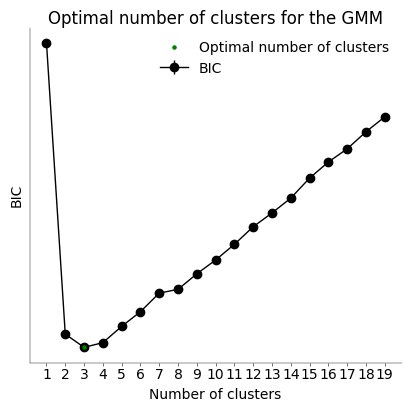

In [70]:
### Dimensionality reduction###
reduced_data_ = dim_reduction(ephysData_filtered, cluster_colors[keepcells])
pca_ePhys = reduced_data_["PCA"]["data"]
pca_ePhys_cluster_n = get_optimal_cluster_number(
    possible_clusters, num_seeds, pca_ePhys, bic_mode="sklearn", plot=True
)

### GMM CLUSTERING ###
pca_ePhys_gmm = GMM(n_components=pca_ePhys_cluster_n, random_state=42).fit(pca_ePhys)
pca_ePhys_clusters = pca_ePhys_gmm.predict(pca_ePhys)
pca_ePhys_clusters_means = pca_ePhys_gmm.means_
pca_ePhys_clusters_covariances = pca_ePhys_gmm.covariances_

/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_34313/3889043698.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_34313/3889043698.py:44: UserWarn

Text(0.5, 0.98, 'PCA and tSNE of ePhys data with original labeling')

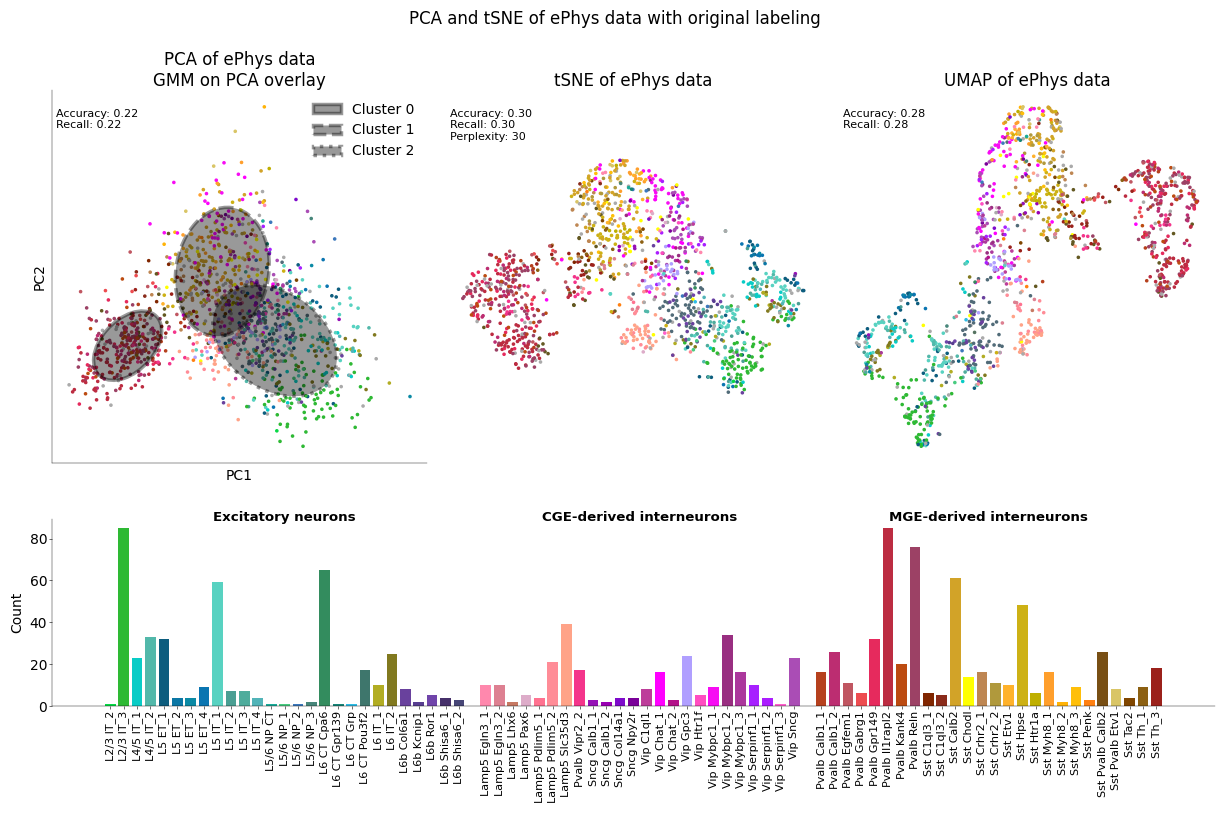

In [71]:
### PLOTTING ###
fig = plt.figure(figsize=(15, 8))

gs = GridSpec(2, 3, figure=fig, wspace=0.05, height_ratios=[2, 1])
# Create subplots with the specified gridspec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])


plot_dim1_dim2(
    ax0,
    reduced_data_,
    cluster_colors[keepcells],
    "PCA of ePhys data\nGMM on PCA overlay",
    type="PCA",
    display_stats=True,
)
plot_TSNE(
    ax1,
    ePhys_tsne,
    cluster_colors[keepcells],
    "tSNE of ePhys data",
    display_accuracy=True,
)
plot_umap(
    ax2,
    umap_ePhys,
    cluster_colors[keepcells],
    "UMAP of ePhys data",
    display_accuracy=True,
)
plot_cell_types(neuron_groups, ax3, base_font_size=8)

plot_ellipse(
    pca_ePhys_clusters_means,
    pca_ePhys_clusters_covariances,
    ax=ax0,
    color="black",
    cluster_n=pca_ePhys_cluster_n,
)
ax0.legend()
plt.tight_layout()
plt.suptitle("PCA and tSNE of ePhys data with original labeling", fontsize=12)

#### Summary

Our analysis demonstrates that Pvalb MGE-derived interneurons are distinctly separated from other cell types in both PCA, t-SNE, and UMAP projections. This finding is consistent with the original study, aligning with the known characteristic of high firing rates in these interneurons. The Gaussian Mixture Model (GMM) clustering further validates this separation, both in PCA-reduced and raw data spaces.

Moreover, excitatory neurons form distinct clusters in all three dimensionality reduction techniques. The GMM applied to the raw data (with an optimal cluster number of 4) effectively segregates excitatory neurons. Conversely, the GMM applied to PCA-reduced data (optimal cluster number of 3) exhibits slightly reduced performance, misclassifying some CGE-derived interneurons within the excitatory neuron cluster.

In contrast, the CGE-derived and MGE-derived interneurons do not exhibit clear separation as whole families within the electrophysiological space. They are consistently clustered together, indicating overlapping electrophysiological properties that complicate their distinct classification using the methods applied.

K-nearest neighbors classification yields some information loss after PCA dimensionality reduction (0.33 accuracy in original data vs 0.22 in the PCA-space), which is a common trade-off in such analyses. TSNE and UMAP show better accuracy: 0.30 and 0.28 respectively.

As for the dimensionality reduction, the raw data might have more complex structures that GMM can capture better, leading to more clusters (4 vs 3). PCA simplifies the data, which might merge some of these structures into fewer clusters. Overall PCA-based clustering is more efficient and less prone to overfitting, but it might lose some finer details present in the raw data clustering.

### Plotting t-SNE wit different parameters



/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

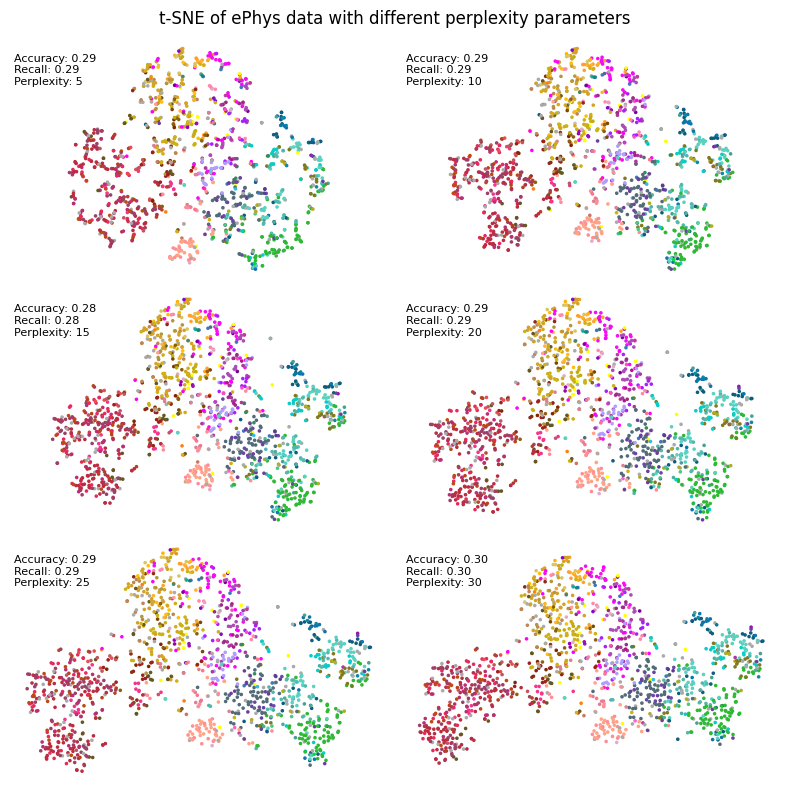

In [72]:
# Initialize list to store t-SNE results
TSNES = []

# Define range of perplexity values to test
perplexities = np.arange(5, 35, 5)

# Calculate number of rows and columns for subplots grid
num_plots = len(perplexities)
ncols = 2
nrows = (num_plots + ncols - 1) // ncols  # Ensure enough rows for the number of plots

# Set up subplots grid
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

# Flatten the axs array if it's 2D
if nrows * ncols > 1:
    axs = axs.flatten()

# Loop through perplexity values and perform t-SNE
for i, p in enumerate(perplexities):
    tsne = TSNE(perplexity=p, random_state=42).fit_transform(ephysData_filtered)
    TSNES.append(tsne)
    ax = axs[i]
    plot_TSNE(
        ax,
        tsne,
        cluster_colors[keepcells],
        title="",
        display_accuracy=True,
        perplexity=p,
    )

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Show the plot

plt.suptitle("t-SNE of ePhys data with different perplexity parameters", fontsize=12)
plt.tight_layout()

The figure shows that according to the k-nearest neighbors classification, TSNE with the perplexity parameter 30 has the highest accuracy. This is also the default parameter, which was used in other plots in this study

### Representing ePhys data in PCA, TSNE and UMAP spaces with previusly obtained GMM-labeling

In [73]:
gmm_reduced_data = dim_reduction(ephysData_filtered, ePhys_clusters)

PCA accuracy: 0.89
PCA recall: 0.89
NCA accuracy: 0.91
NCA recall: 0.91
LDA accuracy: 0.90
LDA recall: 0.90


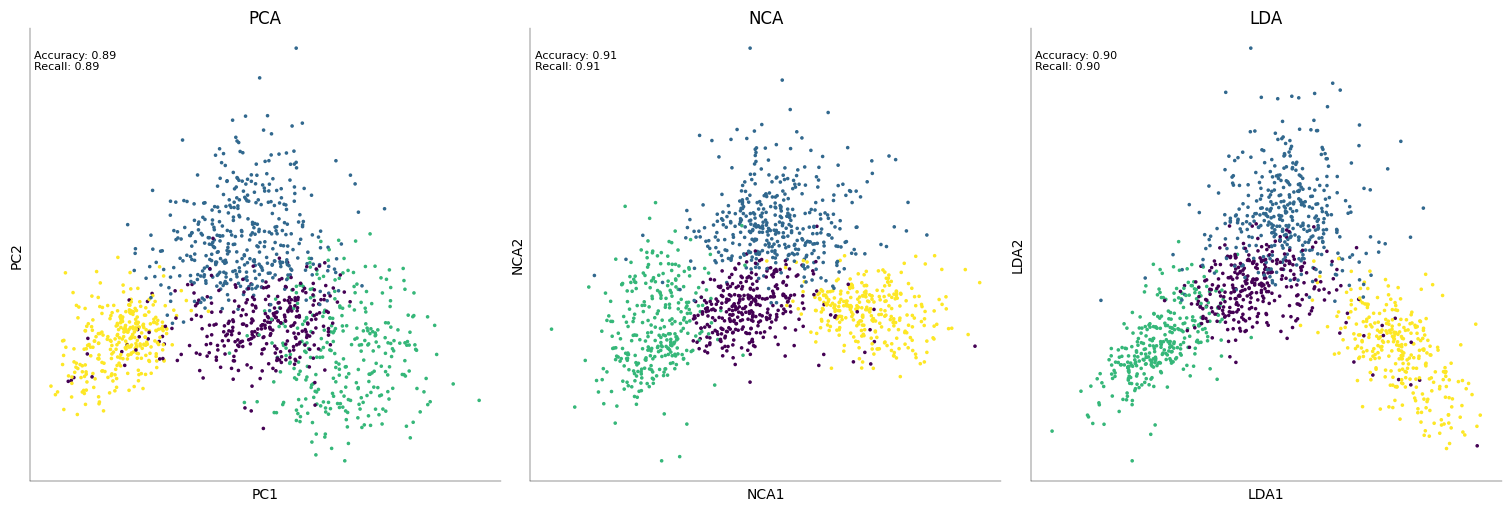

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (key, value) in enumerate(gmm_reduced_data.items()):
    plot_dim1_dim2(
        ax[i],
        gmm_reduced_data,
        ePhys_clusters,
        type=key,
        title=key,
        display_stats=True,
    )

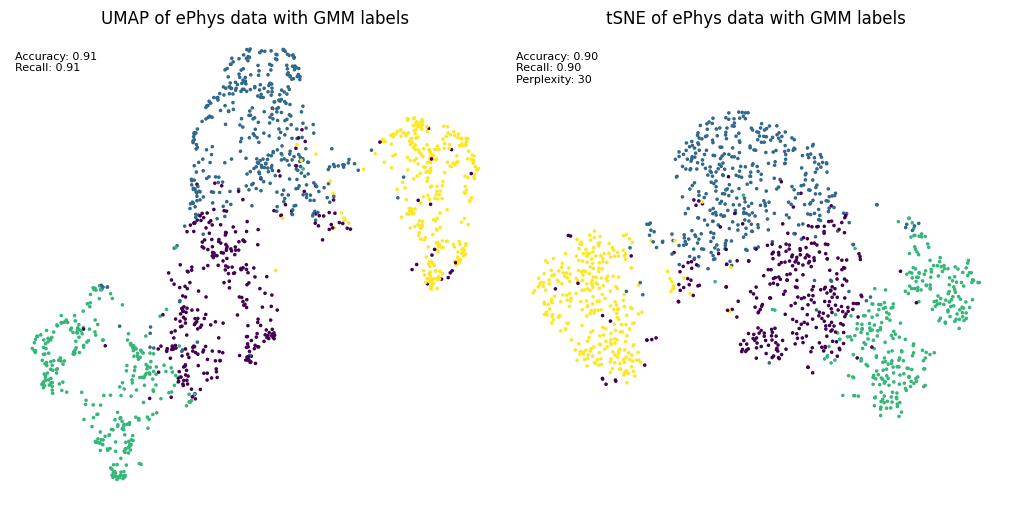

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_umap(
    ax[0],
    umap_ePhys,
    ePhys_clusters,
    "UMAP of ePhys data with GMM labels",
    display_accuracy=True,
)
plot_TSNE(
    ax[1],
    ePhys_tsne,
    ePhys_clusters,
    "tSNE of ePhys data with GMM labels",
    display_accuracy=True,
)

#### We can compare GMM labeling with original labeling

/Users/a1/Desktop/NDS Project/NDS_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 0.98, 'Comparison of PCA and t-SNE of ePhys data with original and GMM labels')

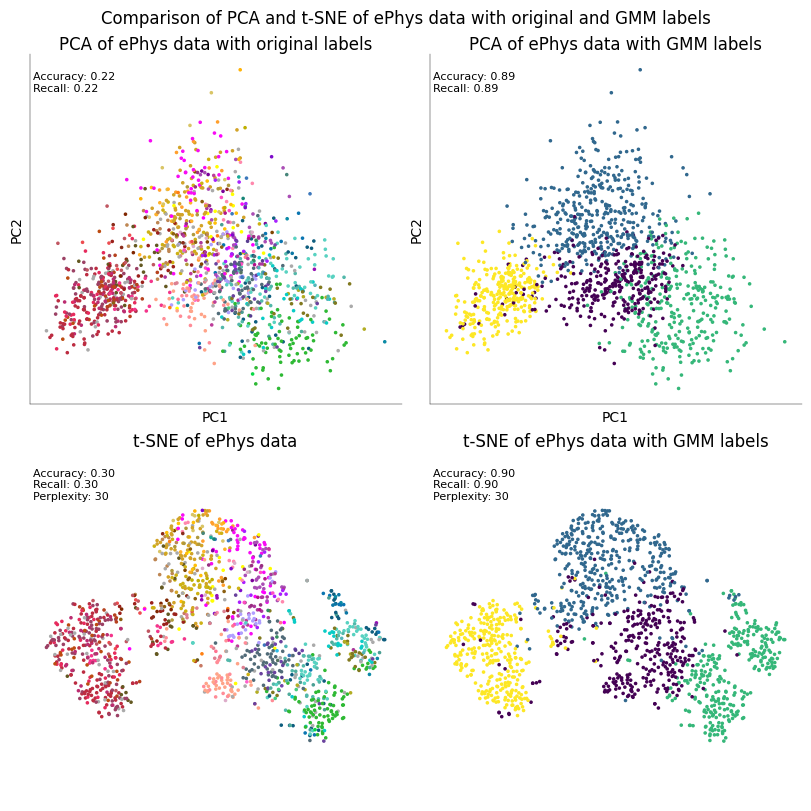

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

plot_dim1_dim2(
    ax[0, 0],
    reduced_data,
    cluster_colors[keepcells],
    "PCA of ePhys data with original labels",
    type="PCA",
    display_stats=True,
)
plot_dim1_dim2(
    ax[0, 1],
    gmm_reduced_data,
    ePhys_clusters,
    "PCA of ePhys data with GMM labels",
    type="PCA",
    display_stats=True,
)


plot_TSNE(
    ax[1, 0],
    ePhys_tsne,
    cluster_colors[keepcells],
    "t-SNE of ePhys data",
    display_accuracy=True,
)
plot_TSNE(
    ax[1, 1],
    ePhys_tsne,
    ePhys_clusters,
    "t-SNE of ePhys data with GMM labels",
    display_accuracy=True,
)
plt.suptitle("Comparison of PCA and t-SNE of ePhys data with original and GMM labels")

#### Summary

As discussed before, using GMM-clustering on raw data yields 4 clusters with high accuracy (assessed by k-nearest neighbors classification). These clusters are well separated in PCA, TSNE and UMAP spaces. Again, yellow cluster distinctively represents the Pvalb cells, while the green cluster corresponds to the excitatory cells. Blue and Purple clusters include a mixture of MGE- and CGE-derived interneurons, which are not well separable by their electrophysiological features. 

#### Creating K-nearest neighbors graph and Leiden partition for ePhys data (Artemii)

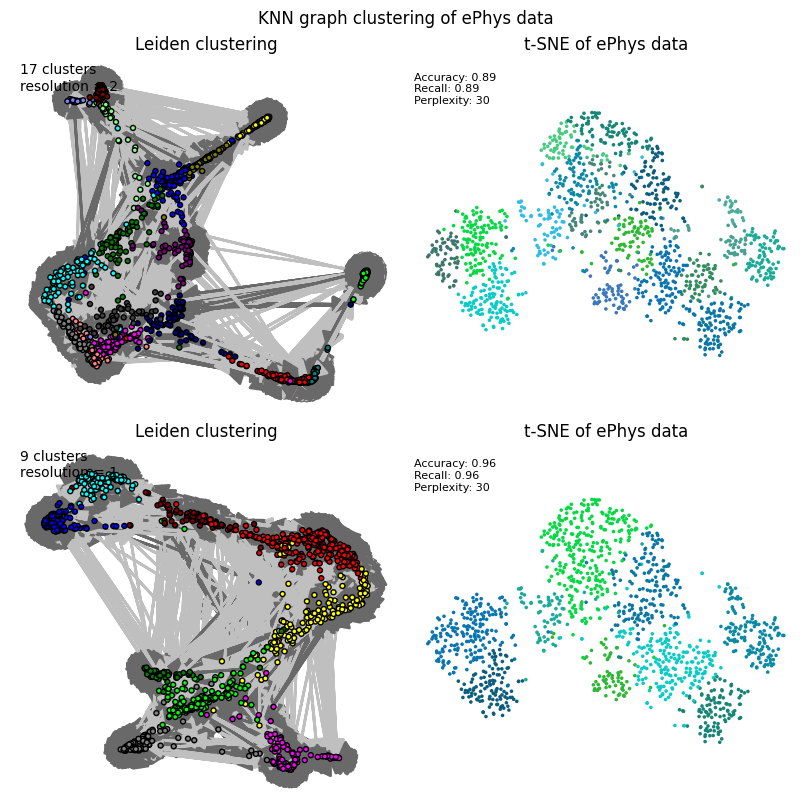

In [77]:
import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la


clusterCols = np.unique(cluster_colors)

data = ephysData_filtered

A = kneighbors_graph(data, 10, mode="connectivity", include_self=False)
sources, targets = A.nonzero()
G = ig.Graph(directed=True)
G.add_vertices(A.shape[0])
edges = list(zip(sources, targets))
G.add_edges(edges)

resolutions = [2, 1]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    partition = la.find_partition(
        G,
        la.RBConfigurationVertexPartition,
        resolution_parameter=resolutions[i],
        seed=42,
    )

    ig.plot(
        partition,
        vertex_size=5,
        edge_curved=False,
        edgecolor="black",
        colors=clusterCols[partition.membership],
        target=ax[i][0],
    )
    ax[i][0].set_title("Leiden clustering")
    ax[i][0].text(
        0.025,
        0.9,
        f"{len(np.unique(partition.membership))} clusters\nresolution = {resolutions[i]}",
        transform=ax[i][0].transAxes,
    )

    plot_TSNE(
        ax[i][1],
        ePhys_tsne,
        clusterCols[partition.membership],
        "t-SNE of ePhys data",
        display_accuracy=True,
    )
    plt.suptitle("KNN graph clustering of ePhys data")

#### Plot selected electrophysiological features for the cells, clustered by GMM

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_34313/1137455490.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


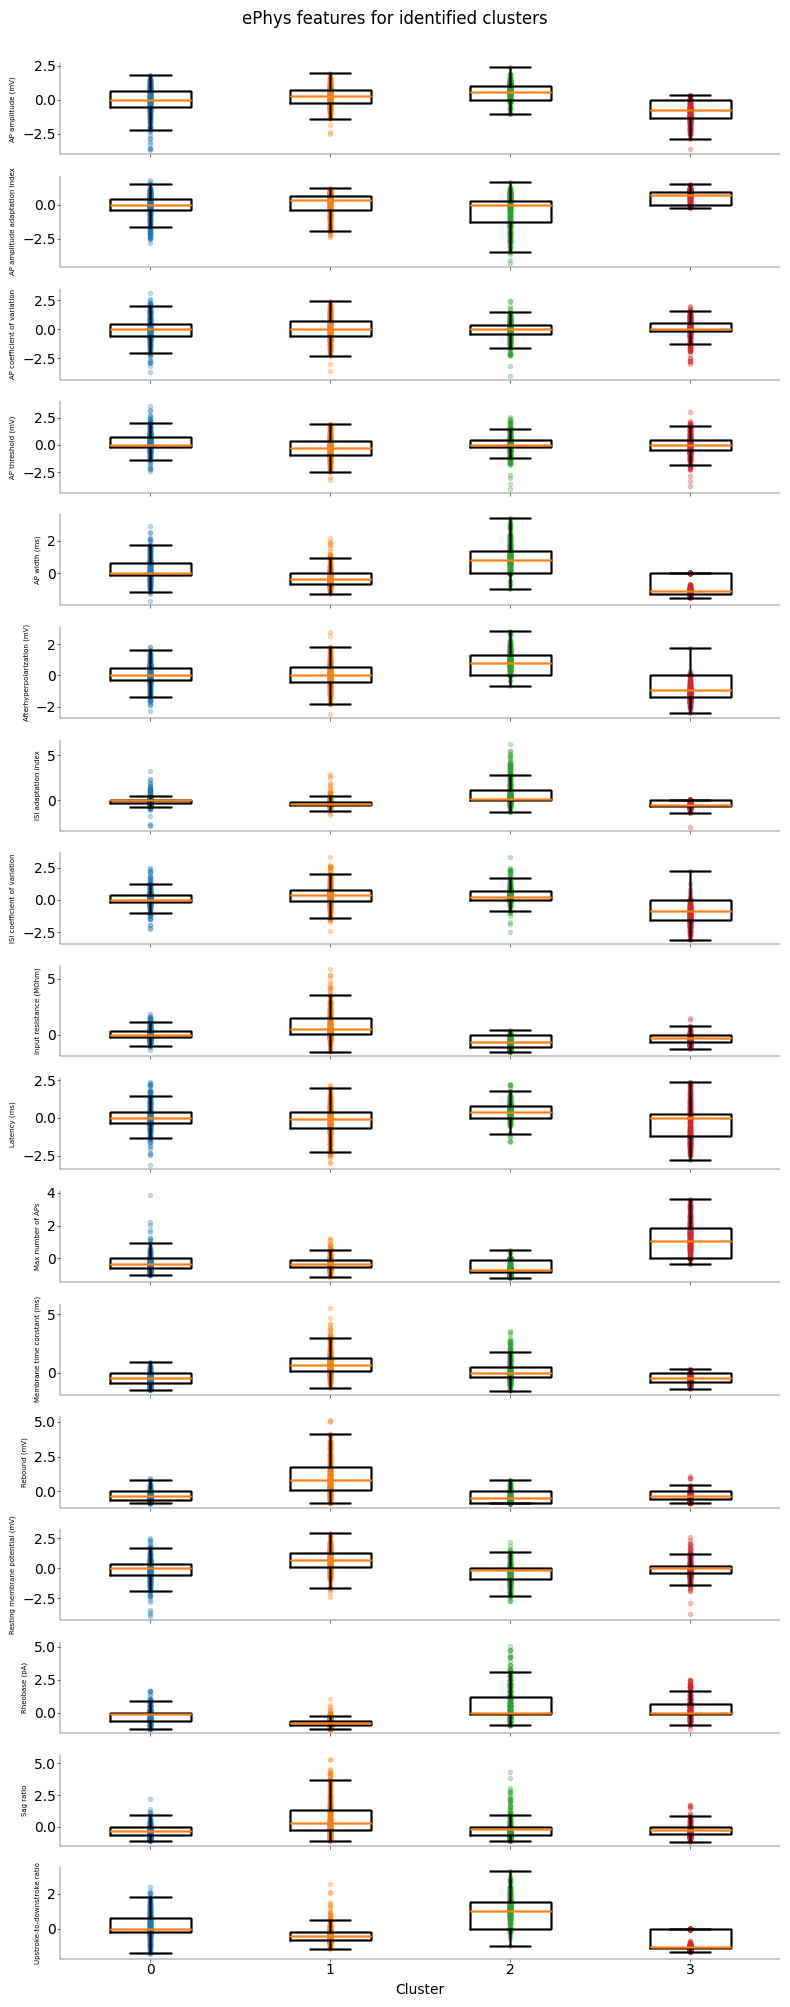

In [78]:
data = ephysData_filtered
features = ephysNames[~np.isin(ephysNames, features_exclude)]
mean_Per_group = np.zeros((len(features), len(np.unique(ePhys_clusters))))
std_Per_group = np.zeros((len(features), len(np.unique(ePhys_clusters))))
for i, c in enumerate(np.unique(ePhys_clusters)):
    mean_Per_group[:, i] = np.mean(data[ePhys_clusters == c, :], axis=0)
    std_Per_group[:, i] = np.std(data[ePhys_clusters == c, :], axis=0)


n_features = features.size
clusters_data = np.zeros((len(features), len(np.unique(ePhys_clusters)), data.shape[0]))

unique_clusters = np.unique(ePhys_clusters)
# Determine the max number of samples in any cluster
max_samples = max(np.sum(ePhys_clusters == c) for c in unique_clusters)

clusters_data = np.zeros((len(features), len(unique_clusters), max_samples))

for i, c in enumerate(unique_clusters):
    cluster_data = data[ePhys_clusters == c, :].T
    clusters_data[:, i, : cluster_data.shape[1]] = cluster_data

fig, ax = plt.subplots(len(features), 1, figsize=(8, 20), sharex=True)
for i, feature in enumerate(features):
    for j, c in enumerate(np.unique(ePhys_clusters)):
        ax[i].scatter(
            np.zeros(clusters_data.shape[2]) + j,
            clusters_data[i, j, :],
            # use the same colors as for gmm clusters
            color=plt.cm.tab10.colors[j],
            alpha=0.25,
        )
        ax[i].boxplot(
            clusters_data[i, :, :].T,
            positions=np.arange(len(np.unique(ePhys_clusters))),
            showfliers=False,
            patch_artist=False,
        )

    ax[i].set_xticks(np.arange(len(np.unique(ePhys_clusters))))
    ax[i].set_xticklabels(np.unique(ePhys_clusters))
    ax[i].set_ylabel(feature, fontsize=5)
    ax[i].set_xlabel("Cluster") if i == len(features) - 1 else None
plt.suptitle("ePhys features for identified clusters", y=1.001)
plt.tight_layout()